In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [41]:
from pathlib import Path

FIG_DIR = Path("../reports/figures")
TAB_DIR = Path("../reports/tables")
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

In [42]:
# load df

df_raw = pd.read_csv("../data/processed/merged4_df.csv")
df = df_raw.copy()
df = df.drop(columns=[c for c in df.columns if c.startswith(("Range_k","Quantile_k","Cluster_jacc_"))],
             errors="ignore")

df.shape
df.head()

,id,max_corsi,corsi_minmax,conditional_correct,conditional_minmax,mental_accuracy,mental_minmax,spatial_arrag_correct,spatial_arrag_minmax,spatial_rel_correct,...,nvc_count_maxscaled,crt_correct,crt_minmax,NFC,NFC_minmax,verbal,verbal_minmax,wason_correct,wason_minmax,jacc
0,participant_1,7,0.666667,0.500,0.500,0.45,0.45,0.55,0.55,0.40625,...,0.00000,0.285714,0.285714,3.75,0.458333,0.250,0.250,0.333333,0.333333,0.333333
1,participant_10,7,0.666667,0.500,0.500,0.45,0.45,0.70,0.70,0.40625,...,0.15625,0.571429,0.571429,3.50,0.416667,0.375,0.375,0.500000,0.500000,0.136719
2,participant_100,7,0.666667,0.500,0.500,0.00,0.00,0.60,0.60,0.40625,...,0.00000,0.571429,0.571429,3.75,0.458333,0.000,0.000,0.500000,0.500000,0.269531
3,participant_101,6,0.555556,0.375,0.375,0.15,0.15,0.70,0.70,0.46875,...,0.09375,0.714286,0.714286,5.00,0.666667,0.500,0.500,1.000000,1.000000,0.260417
4,participant_102,7,0.666667,0.500,0.500,0.10,0.10,0.80,0.80,0.31250,...,0.00000,0.571429,0.571429,3.50,0.416667,0.125,0.125,0.000000,0.000000,0.252604


In [43]:
# 2 clustering methods 


TARGET = "jacc"
K_LIST = (2,3,4,5)


def assign_range_clusters(df, score_col = "jacc", k_list = K_LIST):
    scores = df[score_col].values
    min_val, max_val = scores.min(), scores.max()

    for k in k_list:
        bins = np.linspace(min_val, max_val, k+1)
        df[f"Range_k{k}"] = np.digitize(scores, bins[1:], right=True)
    return df

def assign_quantile_clusters(df, target_col = "jacc", k_list = K_LIST):
    for k in k_list :
        df[f"Quantile_k{k}"] = pd.qcut(df[target_col], q = k , labels = False, duplicates = "drop")
    return df



In [44]:
df = assign_range_clusters(df)
df = assign_quantile_clusters(df)

In [45]:
# Baseline summary (NOT LOOCV evaluation)
# - global mean of jacc (descriptive)
# - group means by Range_k* and Quantile_k* (descriptive)
# These are used for sanity-check / interpretation.
# The actual baseline performance is computed later with LOOCV.

# Safety: ensure we are using the correct target distribution
assert df[TARGET].notna().sum() == 95
assert abs(df[TARGET].mean() - 0.3141776315789474) < 1e-12

# baseline 

def compute_cluster_loocv_mae(df, cluster_col, target_col = TARGET):
    errors = [ ]
    for _, group in df.groupby(cluster_col):
        y = group[target_col].values
        if len(y) <=1:
            continue
        for i in range(len(y)):
            pred = np.mean(np.delete(y,i))
            errors.append(abs(y[i] - pred))
    return float(np.mean(errors)) if errors else np.nan 

# 1) global baseline (loocv)
y = df[TARGET]
pred_global = (y.sum() - y) / (len(y) - 1)
mae_global = (y - pred_global).abs().mean()



# 2) group baselines (loocv) 
range_mae = {k : compute_cluster_loocv_mae(df, f"Range_k{k}") for k in K_LIST}
quantile_mae = {k : compute_cluster_loocv_mae(df, f"Quantile_k{k}") for k in K_LIST}

baseline_mae_table = pd.DataFrame({
    "method" : (["global_mean_loocv"] + 
                [f"range_k{k}" for k in K_LIST] + 
                [f"quantile_k{k}" for k in K_LIST]),
    "mae" : ([mae_global] + 
             [range_mae[k] for k in K_LIST] +
             [quantile_mae[k] for k in K_LIST])
})

# Save
baseline_mae_table.to_csv(TAB_DIR / "baseline_loocv_mae.csv", index = False)
baseline_mae_table

,method,mae
0,global_mean_loocv,0.151546
1,range_k2,0.083338
2,range_k3,0.061561
3,range_k4,0.042372
4,range_k5,0.034744
5,quantile_k2,0.088175
6,quantile_k3,0.055962
7,quantile_k4,0.039886
8,quantile_k5,0.037491


In [46]:
# baseline MAE visualize 

tmp = baseline_mae_table.sort_values("mae")
plt.figure(figsize = (8, 4))
plt.bar(tmp["method"], tmp["mae"])
plt.xticks(rotation = 45, ha = "right")
plt.ylabel("MAE (LOOCV)")
plt.tight_layout()
plt.savefig(FIG_DIR / "baseline_loocv_mae.png", dpi = 200, bbox_inches = "tight")
plt.close()

In [47]:
DEPTH_LIST = (2, 3, 4, 5)
feature_cols = [
    'conditional_minmax', 'mental_minmax', 
    'spatial_arrag_minmax', 'spatial_rel_minmax', 'nvc_count_maxscaled', 
    'crt_minmax', 'NFC_minmax','corsi_minmax', 'verbal_minmax', 'wason_minmax'
]

def loocv_dt_classifier_then_cluster_mean(df, feature_cols, cluster_col, target_col = TARGET, max_depth = 2, random_state = 2): 
    errors = []
    X_full = df[feature_cols]
    y_cluster = df[cluster_col].values
    y= df[target_col].values
    loo = LeaveOneOut()

    for train_idx, test_idx in loo.split(X_full):
        X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
        y_train_cluster = y_cluster[train_idx]
        y_train = y[train_idx]
        true_y = y[test_idx[0]]

        clf = DecisionTreeClassifier(max_depth= max_depth, random_state=random_state)
        clf.fit(X_train, y_train_cluster)

        pred_cluster = clf.predict(X_test)[0]
        cluster_targets = y_train[y_train_cluster == pred_cluster]
        if len(cluster_targets) == 0:
            continue
        pred_y = cluster_targets.mean()
        errors.append(abs(pred_y - true_y))
    return float(np.mean(errors)) if errors else np.nan 

def loocv_df_regressor(df, feature_cols, target_col = TARGET, max_depth = 2, random_state = 2):
    errors = [ ]
    X_full = df[feature_cols]
    y = df[target_col].values
    loo = LeaveOneOut()

    for train_idx, test_idx in loo.split(X_full):
        X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
        y_train = y[train_idx]
        true_y = y[test_idx[0]]

        reg = DecisionTreeRegressor(max_depth = max_depth, random_state = random_state)
        reg.fit(X_train, y_train)

        pred_y = reg.predict(X_test)[0]
        errors.append(abs(pred_y - true_y))
    return float(np.mean(errors)) if errors else np.nan

In [66]:
rows = []

# (A) Range grouping : DT classifier -> cluster mean (k x depth)
for depth in DEPTH_LIST:
    for k in K_LIST:
        mae = loocv_dt_classifier_then_cluster_mean(
            df, 
            feature_cols = feature_cols,
            cluster_col = f"Range_k{k}",
            target_col = TARGET,
            max_depth = depth,
            random_state = 2
        )
        rows.append({
            "family" : "range",
            "k": k,
            "model": "dt_classifier_then_cluster_mean",
            "depth" : depth,
            "mae" : mae
        })

# (B) Quantile grouping : DT classifier -> cluster mean (k x depth)
for depth in DEPTH_LIST:
    for k in K_LIST:
        mae = loocv_dt_classifier_then_cluster_mean(
            df, 
            feature_cols= feature_cols,
            cluster_col= f"Quantile_k{k}",
            target_col=TARGET,
            max_depth= depth,
            random_state= 2
        )
        rows.append({
            "family" : "quantile",
            "k" : k,
            "model" : "dt_classifier_then_cluster_mean",
            "depth" : depth,
            "mae" : mae
        })

# (C) DT regressor (depth only)
for depth in DEPTH_LIST:
    mae = loocv_df_regressor(
        df, 
        feature_cols= feature_cols,
        target_col = TARGET,
        max_depth= depth,
        random_state=2
    )
    rows.append({
        "family" : "regressor",
        "k" : np.nan,
        "model" : "dt_regressor",
        "depth": depth,
        "mae" : mae
        })
    
model_mae_table = pd.DataFrame(rows)

# save
model_mae_table.to_csv(TAB_DIR / "model_loocv_mae.csv", index = False)
model_mae_table.head()

,family,k,model,depth,mae
0,range,2.0,dt_classifier_then_cluster_mean,2,0.127536
1,range,3.0,dt_classifier_then_cluster_mean,2,0.168688
2,range,4.0,dt_classifier_then_cluster_mean,2,0.132487
3,range,5.0,dt_classifier_then_cluster_mean,2,0.173929
4,range,2.0,dt_classifier_then_cluster_mean,3,0.122711


In [49]:
model_mae_table.isna().sum()

family    0
k         4
model     0
depth     0
mae       0
dtype: int64

In [67]:
# 1) baseline_mae_table -> (family, k , depth, mae)
base = baseline_mae_table.copy()

def parse_baseline_method(m):
    if m == "global_mean_loocv":
        return {"family" : "global", "k": np.nan, "model": "baseline_global_mean_loocv", "depth": np.nan}
    if m.startswith("range_k"):
        return {"family" : "range", "k": int(m.split("k")[-1]), "model": "baseline_cluster_mean_loocv", "depth": np.nan}
    if m.startswith("quantile_k"):
        return {"family" : "quantile", "k": int(m.split("k")[-1]), "model": "baseline_cluster_mean_loocv", "depth": np.nan}
    return {"family": "other", "k" : np.nan, "model" : m, "depth": np.nan}

base_meta = base["method"].apply(parse_baseline_method).apply(pd.Series)
baseline_full = pd.concat([base_meta, base[["mae"]]], axis = 1)

# 2) concat baseline + model 
all_mae_table = pd.concat([baseline_full, model_mae_table], ignore_index = True)

# 3) save
all_mae_table.to_csv(TAB_DIR / "loocv_mae_all.csv", index = False)

all_mae_table.sort_values("mae").head(15)

,family,k,model,depth,mae
4,range,5.0,baseline_cluster_mean_loocv,NaN,0.034744
8,quantile,5.0,baseline_cluster_mean_loocv,NaN,0.037491
7,quantile,4.0,baseline_cluster_mean_loocv,NaN,0.039886
3,range,4.0,baseline_cluster_mean_loocv,NaN,0.042372
6,quantile,3.0,baseline_cluster_mean_loocv,NaN,0.055962
2,range,3.0,baseline_cluster_mean_loocv,NaN,0.061561
1,range,2.0,baseline_cluster_mean_loocv,NaN,0.083338
5,quantile,2.0,baseline_cluster_mean_loocv,NaN,0.088175
28,quantile,5.0,dt_classifier_then_cluster_mean,2.0,0.111927
13,range,2.0,dt_classifier_then_cluster_mean,3.0,0.122711


In [51]:
all_mae_table.shape
all_mae_table["family"].value_counts()

family
range        20
quantile     20
regressor     4
global        1
Name: count, dtype: int64

In [68]:
# best vs. baseline

# baselines
base_global = all_mae_table[all_mae_table["model"] == "baseline_global_mean_loocv"].head(1)
base_range = all_mae_table[(all_mae_table["family"] == "range") & (all_mae_table["model"] == "baseline_cluster_mean_loocv")].sort_values("mae").head(1)
base_quantile = all_mae_table[(all_mae_table["family"] == "quantile") & (all_mae_table["model"] == "baseline_cluster_mean_loocv")].sort_values("mae").head(1)

# bset models 
best_range = all_mae_table[(all_mae_table["family"] == "range") & (all_mae_table["model"] == "dt_classifier_then_cluster_mean")].sort_values("mae").head(1)
best_quantile = all_mae_table[(all_mae_table["family"] == "quantile") & (all_mae_table["model"] == "dt_classifier_then_cluster_mean")].sort_values("mae").head(1)
best_reg = all_mae_table[(all_mae_table["model"] == "dt_regressor")].sort_values("mae").head(1)

summary = pd.concat([base_global, base_range, base_quantile, best_range, best_quantile, best_reg], ignore_index = True)

def make_label(r):
    parts = [r["model"]]
    if r["family"] in ("range", "quantile"):
        parts.append(r["family"])
    if pd.notna(r["k"]):
        parts.append(f"k={int(r['k'])}")
    if pd.notna(r["depth"]):
        parts.append(f"depth={int(r['depth'])}")
    return " | ".join(parts)

summary["label"] = summary.apply(make_label, axis = 1)
summary = summary.sort_values("mae", ascending = True)

plt.figure(figsize = (9,4))
plt.barh(summary["label"], summary["mae"])
plt.xlabel("MAE (LOOCV)")
plt.title("Summary : best models vs. baselines")
plt.tight_layout()
plt.savefig(FIG_DIR / "mae_summary_best.png", dpi = 200, bbox_inches = "tight")
plt.close()

summary.to_csv(TAB_DIR / "mae_summary_best.csv", index = False)
summary 

,family,k,model,depth,mae,label
1,range,5.0,baseline_cluster_mean_loocv,NaN,0.034744,baseline_cluster_mean_loocv | range | k=5
2,quantile,5.0,baseline_cluster_mean_loocv,NaN,0.037491,baseline_cluster_mean_loocv | quantile | k=5
4,quantile,5.0,dt_classifier_then_cluster_mean,2.0,0.111927,dt_classifier_then_cluster_mean | quantile | k...
3,range,2.0,dt_classifier_then_cluster_mean,3.0,0.122711,dt_classifier_then_cluster_mean | range | k=2 ...
5,regressor,NaN,dt_regressor,3.0,0.132262,dt_regressor | depth=3
0,global,NaN,baseline_global_mean_loocv,NaN,0.151546,baseline_global_mean_loocv


In [69]:
cluster_counts = list(K_LIST)

# 1) global baseline : horizonal line across k
global_mae = all_mae_table.loc[
    all_mae_table["model"] == "baseline_global_mean_loocv", "mae"
].iloc[0]
global_line = [global_mae] * len(cluster_counts)

# 2) range baseline per k
range_base = all_mae_table[
    (all_mae_table["family"] == "range") &
    (all_mae_table["model"] == "baseline_cluster_mean_loocv")
].sort_values("k")
range_base_y = [range_base.loc[range_base["k"] == k, "mae"].iloc[0] for k in cluster_counts]

# 3) quantile baseline per k
quant_base = all_mae_table[
    (all_mae_table["family"] == "quantile") & 
    (all_mae_table["model"] == "baseline_cluster_mean_loocv") 
].sort_values("k")
quant_base_y = [quant_base.loc[quant_base["k"] == k, "mae"].iloc[0] for k in cluster_counts]

# 4) range classifier per depth 
def get_classifier_curve(family, depth):
    sub = all_mae_table[
        (all_mae_table["family"] == family) &
        (all_mae_table["model"] == "dt_classifier_then_cluster_mean") &
        (all_mae_table["depth"] == depth)
    ].sort_values("k")
    return [sub.loc[sub["k"] == k, "mae"].iloc[0] for k in cluster_counts]

# 5) regressor per depth (no k) -> replicate across k 
def get_regressor_line(depth):
    v = all_mae_table[
        (all_mae_table["model"] == "dt_regressor") &
        (all_mae_table["depth"] == depth)
    ]["mae"].iloc[0]
    return [v] * len(cluster_counts)

plt.figure(figsize = (9, 5))

# global baseline
plt.plot(cluster_counts, global_line, linestyle = "--", marker = "o", label = "Global Baseline (LOOCV)")

# baselines
plt.plot(cluster_counts, range_base_y, marker = "o", label = "Range Baseline (LOOCV)")
plt.plot(cluster_counts, quant_base_y, marker = "o", label = "Quantile Baseline (LOOCV)")

# range classifier depths
for depth in DEPTH_LIST:
    y = get_classifier_curve("range", depth)
    plt.plot(cluster_counts, y, marker = "o", label = f"Range Classifier depth = {depth}")

# quantile classifier depths
for depth in DEPTH_LIST:
    y = get_classifier_curve("quantile", depth)
    plt.plot(cluster_counts, y, marker = "s", label = f"Quantile Classifier depth = {depth}")

# regressor depths
for depth in DEPTH_LIST:
    y = get_regressor_line(depth)
    plt.plot(cluster_counts, y, linestyle = ":", label = f"Regressor depth = {depth}")

plt.xticks(cluster_counts)
plt.xlabel("Number of splits (k)")
plt.ylabel("MAE (LOOCV)")
plt.title("MAE Comparison (LOOCV) : Baseline vs. Models")
plt.grid(True)
plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.tight_layout()
plt.savefig(FIG_DIR / "mae_comparison_all_in_one.png", dpi = 200, bbox_inches = "tight")
plt.close()

In [72]:

import statsmodels.api as sm
from itertools import combinations


FEATURES = [
    'conditional_minmax','mental_minmax','spatial_arrag_minmax','spatial_rel_minmax',
    'nvc_count_maxscaled','crt_minmax','NFC_minmax','corsi_minmax','verbal_minmax','wason_minmax'
]

y = df[TARGET]

best_aic = np.inf
best_combo = None
best_model = None

for k in range(1, len(FEATURES)+1):
    for combo in combinations(FEATURES, k):
        X = sm.add_constant(df[list(combo)])
        model = sm.OLS(y, X).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_combo = combo
            best_model = model

coef_table = pd.DataFrame({
    "coef": best_model.params,
    "p_value": best_model.pvalues,
}).reset_index(names="term")

coef_table["aic"] = best_aic
coef_table["selected_features"] = ", ".join(best_combo)

coef_table.to_csv(TAB_DIR / "aic_coefficients.csv", index=False)
coef_table

,term,coef,p_value,aic,selected_features
0,const,-0.154449,0.012504,-98.980177,"conditional_minmax, spatial_rel_minmax, nvc_co..."
1,conditional_minmax,0.286276,0.004175,-98.980177,"conditional_minmax, spatial_rel_minmax, nvc_co..."
2,spatial_rel_minmax,0.406364,0.000020,-98.980177,"conditional_minmax, spatial_rel_minmax, nvc_co..."
3,nvc_count_maxscaled,0.192463,0.053071,-98.980177,"conditional_minmax, spatial_rel_minmax, nvc_co..."
4,crt_minmax,0.127732,0.022145,-98.980177,"conditional_minmax, spatial_rel_minmax, nvc_co..."


In [73]:
X_best = sm.add_constant(df[list(best_combo)])
y_true = df[TARGET]
y_pred = best_model.predict(X_best)

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (AIC-based OLS)")
plt.tight_layout()
plt.savefig(FIG_DIR / "actual_vs_pred_aic_ols.png", dpi=200, bbox_inches="tight")
plt.close()

(FIG_DIR / "actual_vs_pred_aic_ols.png").exists()

True

In [74]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

selected_features = list(best_combo)
X = df[selected_features].values
y = df[TARGET].values

loo = LeaveOneOut()
errors = []

for tr, te in loo.split(X):
    model = LinearRegression()
    model.fit(X[tr], y[tr])
    pred = model.predict(X[te])[0]
    errors.append(abs(pred - y[te][0]))

aic_loocv_mae = float(np.mean(errors))
aic_loocv_mae

0.11846995355699651

In [75]:
aic_rows = pd.DataFrame({
    "family": ["global"] * len(K_LIST),
    "k": list(K_LIST),
    "model": ["linear_aic_selected_loocv"] * len(K_LIST),
    "depth": [np.nan] * len(K_LIST),
    "mae": [aic_loocv_mae] * len(K_LIST),
})

all_mae_table = pd.concat([all_mae_table, aic_rows], ignore_index=True)
all_mae_table.to_csv(TAB_DIR / "loocv_mae_all.csv", index=False)

all_mae_table[all_mae_table["model"]=="linear_aic_selected_loocv"]

,family,k,model,depth,mae
45,global,2.0,linear_aic_selected_loocv,NaN,0.11847
46,global,3.0,linear_aic_selected_loocv,NaN,0.11847
47,global,4.0,linear_aic_selected_loocv,NaN,0.11847
48,global,5.0,linear_aic_selected_loocv,NaN,0.11847


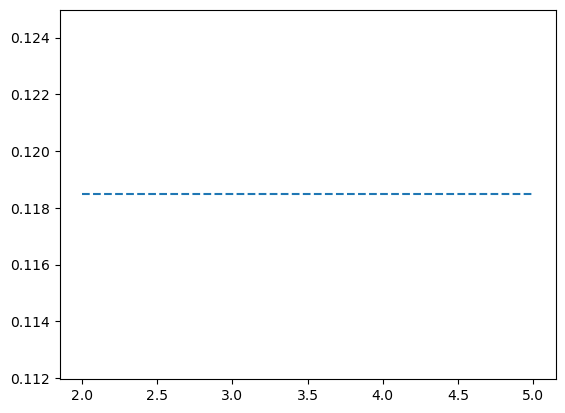

In [76]:
aic_mae = all_mae_table.loc[all_mae_table["model"]=="linear_aic_selected_loocv", "mae"].iloc[0]
plt.plot(cluster_counts, [aic_mae]*len(cluster_counts), linestyle="--", label="AIC Linear (LOOCV)")